In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
from torch.utils.data.dataloader import DataLoader
import torch.utils.data as data_utils
from torch.optim import lr_scheduler
import numpy as np
from scipy import sparse as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import sys,time
import os
import copy
import pickle

In [2]:
redDim=35

In [3]:
# Set print option
np.set_printoptions(threshold=sys.maxsize)

# Choose device that is not being used
gpu_ids = "2"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device, '\n')

Using device: cuda 



In [4]:
# Given parameters
nx = 60
ny = 60
m = (ny-2)*(nx-2) # 3364
nt = 1500

In [5]:
# Choose either Re=10000 or Re=100
Re = 10000 
    
# Choose data normalize option (option 1: -1<=X<=1 option 2: 0<=X<=1)
option = 2

# Choose activation function (sigmoid, swish)
activation = 'sigmoid'

In [6]:
# set batch_size, number of epochs, paitience for early stop
batch_size = 480
num_epochs = 10000
num_epochs_print = num_epochs//100
early_stop_patience = num_epochs//50

In [7]:
# def create_mask(m,b,db):
    
#     M2 = b + db*(m-1)
#     mask = np.zeros((m,M2),dtype='int8')
    
#     block = np.ones(b,dtype='int8')
#     ind = np.arange(b)
#     for row in range(m):
#         col = ind + row*db
#         mask[row,col] = block      

# #     for row in range(nx-2,m):
# #         col = ind + (row-1)*db
# #         mask[row-(nx-2),col] = block    
# #     for row in range(0,m-(nx-2)):
# #         col = ind + (row+1)*db
# #         mask[row+(nx-2),col] = block
                   
#     print(
#         "Sparsity in {} by {} mask: {:.2f}%".format(
#             m, M2, (1.0-np.count_nonzero(mask)/mask.size)*100
#         )
#     )
    
#     plt.figure()
#     plt.spy(mask)
#     plt.show()

#     return mask

In [8]:
def create_mask_2d(m,b,db):
    
    # local
    Mb=sp.diags([np.ones(nx-2),np.ones(nx-2),np.ones(nx-2)],[0,-1,1],(nx-2,nx-2))
    M=sp.kron(sp.eye(ny-2),Mb,format="csr")

    Ib=sp.eye(nx-2)
    N=sp.kron(sp.diags([np.ones(ny-2),np.ones(ny-2),np.ones(ny-2)],[0,-1,1],(ny-2,ny-2)),Ib,format="csr")

    local=(M+N).astype('int8')
    I,J,V=sp.find(local)
    local[I,J]=1
    
#     col_ind=np.array([],dtype='int')
#     row_ind=np.array([],dtype='int')

#     for lin_ind in range(m):
#         j,i=np.unravel_index(lin_ind,(ny-2,nx-2))

#         E=np.ravel_multi_index((j,np.max((i-1,0))),(ny-2,nx-2))
#         W=np.ravel_multi_index((j,np.min((i+1,nx-2-1))),(ny-2,nx-2))
#         S=np.ravel_multi_index((np.max((j-1,0)),i),(ny-2,nx-2))
#         N=np.ravel_multi_index((np.min((j+1,ny-2-1)),i),(ny-2,nx-2))

#         col=np.unique([lin_ind,E,W,S,N])
#         row=lin_ind*np.ones(col.size,dtype='int')

#         col_ind=np.append(col_ind,col)
#         row_ind=np.append(row_ind,row)

#     data=np.ones(row_ind.size,dtype='int')
#     local2=sp.csr_matrix((data,(row_ind,col_ind)),shape=(m,m))

    # basis
    M2 = int(b + db*(m-1))
    basis = np.zeros((m,M2),dtype='int8')

    block = np.ones(b,dtype='int8')
    ind = np.arange(b)
    for row in range(m):
        col = ind + row*db
        basis[row,col] = block
    
    # mask
    col_ind=np.array([],dtype='int8')
    row_ind=np.array([],dtype='int8')
    for i in range(m):
        col=basis[sp.find(local[i])[1]].sum(axis=0).nonzero()[0]
        row=i*np.ones(col.size)

        col_ind=np.append(col_ind,col)
        row_ind=np.append(row_ind,row)

    data=np.ones(row_ind.size,dtype='int8')
    mask=sp.csr_matrix((data,(row_ind,col_ind)),shape=(m,M2)).toarray()
    
    print(
        "Sparsity in {} by {} mask: {:.2f}%".format(
            m, M2, (1.0-np.count_nonzero(mask)/np.prod(mask.shape))*100
        )
    )
    
    plt.figure()
    plt.spy(mask)
    plt.show()

    return mask

In [9]:
if activation=='sigmoid':
    class Encoder(nn.Module):
        def __init__(self,m,M1,f):
            super(Encoder,self).__init__()
            self.full = nn.Sequential(
                nn.Linear(m,M1),
                nn.Sigmoid(),
                nn.Linear(M1,f,bias=False)
            )

        def forward(self, y):     
            y = y.view(-1,m)
            T = self.full(y)
            T = T.squeeze()

            return T

    class Decoder(nn.Module):
        def __init__(self,f,M2,m):
            super(Decoder,self).__init__()
            self.full = nn.Sequential(
                nn.Linear(f,M2),
                nn.Sigmoid(),
                nn.Linear(M2,m,bias=False)
            )

        def forward(self,T):
            T = T.view(-1,f)
            y = self.full(T)
            y = y.squeeze()

            return y
        
elif activation=='swish':
    def silu(input):
        return input * torch.sigmoid(input)

    class SiLU(nn.Module):
        def __init__(self):
            super().__init__()

        def forward(self, input):
            return silu(input)
        
    class Encoder(nn.Module):
        def __init__(self,m,M1,f):
            super(Encoder,self).__init__()
            self.full = nn.Sequential(
                nn.Linear(m,M1),
                SiLU(),
                nn.Linear(M1,f,bias=False)
            )

        def forward(self, y):     
            y = y.view(-1,m)
            T = self.full(y)
            T = T.squeeze()

            return T

    class Decoder(nn.Module):
        def __init__(self,f,M2,m):
            super(Decoder,self).__init__()
            self.full = nn.Sequential(
                nn.Linear(f,M2),
                SiLU(),
                nn.Linear(M2,m,bias=False)
            )

        def forward(self,T):
            T = T.view(-1,f)
            y = self.full(T)
            y = y.squeeze()

            return y
else:
    raise NameError('{} is given for option, but it must be either sigmoid or swish'.format(activation))

In [10]:
# load snapshot
if Re==10000:
    file_name_snapshot="./data/snapshot_full_high_Re.p"
elif Re==100:
    file_name_snapshot="./data/snapshot_full_low_Re.p"
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re)) 

snapshot = pickle.load(open(file_name_snapshot,'rb'))
snapshot_u = snapshot['u'].astype('float32')
snapshot_v = snapshot['v'].astype('float32')

# number of data points
ndata = snapshot_u.shape[0]

# remove BC
multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)

orig_data_u = snapshot_u[:,free_raveled_indicies]
orig_data_v = snapshot_v[:,free_raveled_indicies]

# normalize data
if option==1: # option 1: -1<=X<=1
    print("option {}: -1<=X<=1".format(option))
#     u_ref = np.mean(orig_data_u,axis=0)
#     v_ref = np.mean(orig_data_v,axis=0)   

#     u_scale = np.max(orig_data_u,axis=0)-np.min(orig_data_u,axis=0)
#     v_scale = np.max(orig_data_v,axis=0)-np.min(orig_data_v,axis=0)   
    u_ref = (np.max(orig_data_u,axis=0)+np.min(orig_data_u,axis=0))/2.0
    v_ref = (np.max(orig_data_v,axis=0)+np.min(orig_data_v,axis=0))/2.0
    
    u_scale = (np.max(orig_data_u,axis=0)-np.min(orig_data_u,axis=0))/2.0
    v_scale = (np.max(orig_data_v,axis=0)-np.min(orig_data_v,axis=0))/2.0
    
    u_scale = np.where(u_scale > np.finfo('float32').resolution, u_scale, 1)
    v_scale = np.where(v_scale > np.finfo('float32').resolution, v_scale, 1)
    
    u_scale_reciprocal = np.reciprocal(u_scale)
    v_scale_reciprocal = np.reciprocal(v_scale)
    
    data_u = u_scale_reciprocal*(orig_data_u-u_ref)
    data_v = v_scale_reciprocal*(orig_data_v-v_ref)
    
elif option==2: # option 2: 0<=X<=1
    print("option {}: 0<=X<=1".format(option))
    u_ref = np.min(orig_data_u,axis=0)
    v_ref = np.min(orig_data_v,axis=0)
    
    u_scale = np.max(orig_data_u,axis=0)-np.min(orig_data_u,axis=0)
    v_scale = np.max(orig_data_v,axis=0)-np.min(orig_data_v,axis=0)
    
    u_scale = np.where(u_scale > np.finfo('float32').resolution, u_scale, 1)
    v_scale = np.where(v_scale > np.finfo('float32').resolution, v_scale, 1)
    
    u_scale_reciprocal = np.reciprocal(u_scale)
    v_scale_reciprocal = np.reciprocal(v_scale)
    
    data_u = u_scale_reciprocal*(orig_data_u-u_ref)
    data_v = v_scale_reciprocal*(orig_data_v-v_ref)
else:
    raise NameError('{} is given for option, but it must be either 1 or 2'.format(option))

# check shapes of snapshot
print('data shape')
print(data_u.shape)
print(data_v.shape)

# restore data
rest_data_u = u_ref + u_scale*data_u
rest_data_v = v_ref + v_scale*data_v

# check precision
print('maximum abs difference')
print(np.max(np.abs(orig_data_u-rest_data_u)))
print(np.max(np.abs(orig_data_v-rest_data_v)))

option 2: 0<=X<=1
data shape
(6004, 3364)
(6004, 3364)
maximum abs difference
1.1920929e-07
1.1920929e-07


In [11]:
# # generate mesh grid
# [xv,yv]=np.meshgrid(np.linspace(0,1,nx),np.linspace(0,1,ny),indexing='xy')
# x=xv.flatten()
# y=yv.flatten()

# x_free=x[free_raveled_indicies]
# y_free=y[free_raveled_indicies]

# k=0

# # plot original data
# fig_u = plt.figure()
# ax_u = Axes3D(fig_u)
# ax_u.plot_surface(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), orig_data_u[k].reshape(ny-2,nx-2),cmap=cm.viridis, rstride=1, cstride=1)
# ax_u.view_init(elev=30,azim=30)
# # ax_u = fig_u.gca()
# # p_u=ax_u.pcolor(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), orig_data_u[k].reshape(ny-2,nx-2))
# # cb_u=fig_u.colorbar(p_u,ax=ax_u)
# ax_u.set_xlabel('$x_{free}$')
# ax_u.set_ylabel('$y_{free}$')
# plt.title('Original $u$')
# plt.show()

# fig_v = plt.figure()
# ax_v = Axes3D(fig_v)
# ax_v.plot_surface(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), orig_data_v[k].reshape(ny-2,nx-2),cmap=cm.viridis, rstride=1, cstride=1)
# ax_v.view_init(elev=30,azim=60)
# # ax_v = fig_v.gca()
# # p_v=ax_v.pcolor(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), orig_data_v[k].reshape(ny-2,nx-2))
# # cb_v=fig_v.colorbar(p_v,ax=ax_v)
# ax_v.set_xlabel('$x_{free}$')
# ax_v.set_ylabel('$y_{free}$')
# plt.title('Original $v$')
# plt.show()

# # plot preprocessed data
# fig_u = plt.figure()
# ax_u = Axes3D(fig_u)
# ax_u.plot_surface(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), data_u[k].reshape(ny-2,nx-2),cmap=cm.viridis, rstride=1, cstride=1)
# ax_u.view_init(elev=30,azim=30)
# # ax_u = fig_u.gca()
# # p_u=ax_u.pcolor(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), data_u[k].reshape(ny-2,nx-2))
# # cb_u=fig_u.colorbar(p_u,ax=ax_u)
# ax_u.set_xlabel('$x_{free}$')
# ax_u.set_ylabel('$y_{free}$')
# plt.title('Preprocessed $u$')
# plt.show()

# fig_v = plt.figure()
# ax_v = Axes3D(fig_v)
# ax_v.plot_surface(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), data_v[k].reshape(ny-2,nx-2),cmap=cm.viridis, rstride=1, cstride=1)
# ax_v.view_init(elev=30,azim=60)
# # ax_v = fig_v.gca()
# # p_v=ax_v.pcolor(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), data_v[k].reshape(ny-2,nx-2))
# # cb_v=fig_v.colorbar(p_v,ax=ax_v)
# ax_v.set_xlabel('$x_{free}$')
# ax_v.set_ylabel('$y_{free}$')
# plt.title('Preprocessed $v$')
# plt.show()

# # plot restored data
# fig_u = plt.figure()
# ax_u = Axes3D(fig_u)
# ax_u.plot_surface(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), rest_data_u[k].reshape(ny-2,nx-2),cmap=cm.viridis, rstride=1, cstride=1)
# ax_u.view_init(elev=30,azim=30)
# # ax_u = fig_u.gca()
# # p_u=ax_u.pcolor(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), rest_data_u[k].reshape(ny-2,nx-2))
# # cb_u=fig_u.colorbar(p_u,ax=ax_u)
# ax_u.set_xlabel('$x_{free}$')
# ax_u.set_ylabel('$y_{free}$')
# plt.title('Restored $u$')
# plt.show()

# fig_v = plt.figure()
# ax_v = Axes3D(fig_v)
# ax_v.plot_surface(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), rest_data_v[k].reshape(ny-2,nx-2),cmap=cm.viridis, rstride=1, cstride=1)
# ax_v.view_init(elev=30,azim=60)
# # ax_v = fig_v.gca()
# # p_v=ax_v.pcolor(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), rest_data_v[k].reshape(ny-2,nx-2))
# # cb_v=fig_v.colorbar(p_v,ax=ax_v)
# ax_v.set_xlabel('$x_{free}$')
# ax_v.set_ylabel('$y_{free}$')
# plt.title('Restored $v$')
# plt.show()

In [12]:
# define testset and trainset indices
nset = round(ndata/(nt+1))
test_ind = np.array([],dtype='int')
for foo in range(nset):
    rand_ind = np.random.permutation(np.arange(foo*(nt+1)+1,(foo+1)*(nt+1)))[:int(0.1*(nt+1))]
    test_ind = np.append(test_ind,rand_ind)
train_ind = np.setdiff1d(np.arange(ndata),test_ind)

# set trainset and testset
trainset_u = data_u[train_ind]
trainset_v = data_v[train_ind]
testset_u = data_u[test_ind] 
testset_v = data_v[test_ind] 

# set dataset
dataset_u = {'train':data_utils.TensorDataset(torch.tensor(trainset_u,dtype=torch.float32)),
           'test':data_utils.TensorDataset(torch.tensor(testset_u,dtype=torch.float32))}
dataset_v = {'train':data_utils.TensorDataset(torch.tensor(trainset_v,dtype=torch.float32)),
           'test':data_utils.TensorDataset(torch.tensor(testset_v,dtype=torch.float32))}

print(dataset_u['train'].tensors[0].shape, dataset_u['test'].tensors[0].shape)
print(dataset_v['train'].tensors[0].shape, dataset_v['test'].tensors[0].shape)

torch.Size([5404, 3364]) torch.Size([600, 3364])
torch.Size([5404, 3364]) torch.Size([600, 3364])


In [13]:
# compute dataset shapes
dataset_u_shapes = {'train':trainset_u.shape,
                    'test':testset_u.shape}
dataset_v_shapes = {'train':trainset_v.shape,
                    'test':testset_v.shape}

print(dataset_u_shapes['train'],dataset_u_shapes['test'])
print(dataset_v_shapes['train'],dataset_v_shapes['test'])

(5404, 3364) (600, 3364)
(5404, 3364) (600, 3364)


In [14]:
# set data loaders
train_loader_u = DataLoader(dataset=dataset_u['train'], 
                          batch_size=batch_size, shuffle=True, num_workers=0)
train_loader_v = DataLoader(dataset=dataset_v['train'], 
                          batch_size=batch_size, shuffle=True, num_workers=0)
test_loader_u = DataLoader(dataset=dataset_u['test'], 
                         batch_size=batch_size, shuffle=True, num_workers=0)
test_loader_v = DataLoader(dataset=dataset_v['test'], 
                         batch_size=batch_size, shuffle=True, num_workers=0)

data_loaders_u = {'train':train_loader_u, 'test':test_loader_u}
data_loaders_v = {'train':train_loader_v, 'test':test_loader_v}

Sparsity in 3364 by 33730 mask: 99.06%


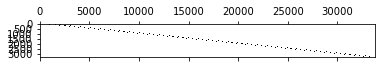

Encoder parameters:2.28752000e+07(0.08522GB) Decoder parameters:2.27800000e+06(0.4272GB)
Data size:2.01974560e+07(0.07524GB)


In [15]:
# set the number of nodes in each layer
a = 2
b = int(100)
db = int(10)

M1 = int(a*m) # encoder hidden layer
M2 = b + (m-1)*db # decoder hidden layer

f = redDim # latent dimension

# sparsity and shape of mask
mask_2d=create_mask_2d(m,b,db)

# number of parameters and memory
en_para=m*M1+M1+M1*f
de_para=f*M2+M2+np.count_nonzero(mask_2d)
print('Encoder parameters:{:.8e}({:.4}GB)'.format(en_para,en_para*4/2**30),\
      'Decoder parameters:{:.8e}({:.4}GB)'.format(de_para,(f*M2+M2+M2*m)*4/2**30))

# data size
data_size=np.prod(orig_data_u.shape)
print('Data size:{:.8e}({:.4}GB)'.format(data_size,data_size*4/2**30))

In [16]:
# Set file names
if Re==10000:
    file_name_AE_u="./model/AE_u_high_Re_v3_red-dim_{}pkl".format(redDim)
    file_name_AE_v="./model/AE_v_high_Re_v3_red-dim_{}.pkl".format(redDim)
    file_name_AE="./model/AE_high_Re_v3_red-dim_{}.p".format(redDim)
    
    PATH_u = './checkpoint_u_high_Re_v3_red-dim_{}.tar'.format(redDim)
    PATH_v = './checkpoint_v_high_Re_v3_red-dim_{}.tar'.format(redDim)
elif Re==100:
    file_name_AE_u="./model/AE_u_low_Re_v3_red-dim_{}.pkl".format(redDim)
    file_name_AE_v="./model/AE_v_low_Re_v3_red-dim_{}.pkl".format(redDim)
    file_name_AE="./model/AE_low_Re_v_3_red-dim_{}.p".format(redDim)
    
    PATH_u = './checkpoint_u_low_Re_v3_red-dim_{}.tar'.format(redDim)
    PATH_v = './checkpoint_v_low_Re_v3_red-dim_{}.tar'.format(redDim)
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))  

In [17]:
# release gpu memory
torch.cuda.empty_cache()

## For u

In [18]:
# load model
try:
    checkpoint = torch.load(PATH_u, map_location=device)
    
    encoder_u = Encoder(m,M1,f).to(device)
    decoder_u = Decoder(f,M2,m).to(device)
    
    # Prune
    prune.custom_from_mask(decoder_u.full[2], name='weight', mask=torch.tensor(mask_2d).to(device))    
       
    optimizer = torch.optim.Adam(list(encoder_u.parameters()) + list(decoder_u.parameters()), lr=0.001)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,patience=10) 
    
    loss_func = nn.MSELoss(reduction='mean')
    
    encoder_u.load_state_dict(checkpoint['encoder_u_state_dict'])
    decoder_u.load_state_dict(checkpoint['decoder_u_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    last_epoch = checkpoint['epoch']
    loss_hist = checkpoint['loss_hist']
    best_loss = checkpoint['best_loss']
    early_stop_counter = checkpoint['early_stop_counter']
    best_encoder_u_wts = checkpoint['best_encoder_u_wts']
    best_decoder_u_wts = checkpoint['best_decoder_u_wts']
    
    print("\n--------checkpoint restored--------\n")

    # resume training
    print("")
    print('Re-start {}th training... m={}, f={},a={}, b={}, db={}'.format(
        last_epoch+1, m, f, a, b, db))
except:
    encoder_u = Encoder(m,M1,f).to(device)
    decoder_u = Decoder(f,M2,m).to(device)
    
    # Prune
    prune.custom_from_mask(decoder_u.full[2], name='weight', mask=torch.tensor(mask_2d).to(device))

    optimizer = torch.optim.Adam(list(encoder_u.parameters()) + list(decoder_u.parameters()), lr=0.001)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,patience=10) 
    
    loss_func = nn.MSELoss(reduction='mean')
    
    last_epoch = 0
    loss_hist = {'train':[],'test':[]}
    best_loss = float("inf")
    early_stop_counter = 1
    best_encoder_u_wts = copy.deepcopy(encoder_u.state_dict())
    best_decoder_u_wts = copy.deepcopy(decoder_u.state_dict())
    
    print("\n--------checkpoint not restored--------\n")

    # start training
    print("")
    print('Start first training... m={}, f={}, a={}, b={}, db={}'\
          .format(m, f, a, b, db))
pass


--------checkpoint not restored--------


Start first training... m=3364, f=35, a=2, b=100, db=10


In [19]:
# train model
since = time.time()

for epoch in range(last_epoch+1,num_epochs+1):   

    if epoch%num_epochs_print == 0:
        print()
        print('Epoch {}/{}, Learning rate {}'.format(
            epoch, num_epochs, optimizer.state_dict()['param_groups'][0]['lr']))
        print('-' * 10)

    # Each epoch has a training and test phase
    for phase in ['train', 'test']:
        if phase == 'train':
            encoder_u.train()  # Set model to training mode
            decoder_u.train()  # Set model to training mode
        else:
            encoder_u.eval()   # Set model to evaluation mode
            decoder_u.eval()   # Set model to evaluation mode
            
        running_loss = 0.0

        # Iterate over data
        for data, in data_loaders_u[phase]:
            inputs = data.to(device)
            targets = data.to(device)

            if phase == 'train':
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = decoder_u(encoder_u(inputs))
                loss = loss_func(outputs, targets)

                # backward
                loss.backward()

                # optimize
                optimizer.step()  

                # add running loss
                running_loss += loss.item()*inputs.shape[0]
            else:
                with torch.set_grad_enabled(False):
                    outputs = decoder_u(encoder_u(inputs))
                    running_loss += loss_func(outputs,targets).item()*inputs.shape[0]

        # compute epoch loss
        epoch_loss = running_loss / dataset_u_shapes[phase][0]
        loss_hist[phase].append(epoch_loss)
            
        # update learning rate
        if phase == 'train':
            scheduler.step(epoch_loss)

        if epoch%num_epochs_print == 0:
            print('{} MSELoss: {}'.format(
                phase, epoch_loss))

    # deep copy the model
    if round(loss_hist['test'][-1],10) < round(best_loss,10):
        best_loss = loss_hist['test'][-1]
        early_stop_counter = 1
        best_encoder_u_wts = copy.deepcopy(encoder_u.state_dict())
        best_decoder_u_wts = copy.deepcopy(decoder_u.state_dict())
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:  
            break
    
    # save checkpoint every num_epoch_print
    if epoch%num_epochs_print== 0:
        torch.save({
                    'epoch': epoch,
                    'encoder_u_state_dict': encoder_u.state_dict(),
                    'decoder_u_state_dict': decoder_u.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss_hist': loss_hist,
                    'best_loss': best_loss,
                    'early_stop_counter': early_stop_counter,
                    'best_encoder_u_wts': best_encoder_u_wts,
                    'best_decoder_u_wts': best_decoder_u_wts,
                    }, PATH_u)        

print()
print('Epoch {}/{}, Learning rate {}'\
      .format(epoch, num_epochs, optimizer.state_dict()['param_groups'][0]['lr']))
print('-' * 10)
print('train MSELoss: {}'.format(loss_hist['train'][-1]))
print('test MSELoss: {}'.format(loss_hist['test'][-1]))

time_elapsed = time.time() - since

# load best model weights
encoder_u.load_state_dict(best_encoder_u_wts)
decoder_u.load_state_dict(best_decoder_u_wts)

# compute best train MSELoss
encoder_u.to('cpu').eval()
decoder_u.to('cpu').eval()

with torch.set_grad_enabled(False):
    train_inputs = torch.tensor(data_u[train_ind])
    train_targets = torch.tensor(data_u[train_ind])
    train_outputs = decoder_u(encoder_u(train_inputs))
    train_loss = loss_func(train_outputs,train_targets).item()

# print out training time and best results
print()
if epoch < num_epochs:
    print('Early stopping: {}th training complete in {:.0f}h {:.0f}m {:.0f}s'\
          .format(epoch-last_epoch, time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
else:
    print('No early stopping: {}th training complete in {:.0f}h {:.0f}m {:.0f}s'\
          .format(epoch-last_epoch, time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
print('-' * 10)
print('Best train MSELoss: {}'.format(train_loss))
print('Best test MSELoss: {}'.format(best_loss))

# # save models
# print()
# print("Saving after {}th training to".format(epoch),file_name_AE_u)
# torch.save((encoder_u,decoder_u),file_name_AE_u)


Epoch 100/10000, Learning rate 0.0001
----------
train MSELoss: 5.180479858075858e-06
test MSELoss: 2.252065678476356e-06

Epoch 200/10000, Learning rate 0.0001
----------
train MSELoss: 1.1340378975043747e-06
test MSELoss: 1.1803150300693233e-06

Epoch 300/10000, Learning rate 0.0001
----------
train MSELoss: 7.527581814675532e-07
test MSELoss: 7.883692319410329e-07

Epoch 400/10000, Learning rate 0.0001
----------
train MSELoss: 4.800647649728535e-07
test MSELoss: 4.941485201470641e-07

Epoch 500/10000, Learning rate 1e-05
----------
train MSELoss: 2.8864358814546606e-07
test MSELoss: 3.0301179663183577e-07

Epoch 600/10000, Learning rate 1e-05
----------
train MSELoss: 2.7221702145745574e-07
test MSELoss: 2.857831759683904e-07

Epoch 700/10000, Learning rate 1e-05
----------
train MSELoss: 2.4963796718942954e-07
test MSELoss: 2.6255237912664596e-07

Epoch 800/10000, Learning rate 1e-05
----------
train MSELoss: 2.2080450568042112e-07
test MSELoss: 2.3366920345324616e-07

Epoch 900/

In [20]:
# delete checkpoint
try:
    os.remove(PATH_u)
    print()
    print("checkpoint removed")
except:
    print("no checkpoint exists") 


checkpoint removed


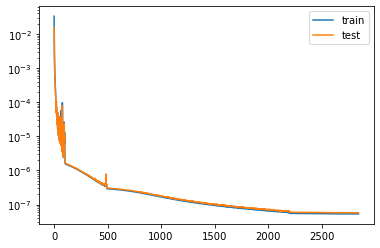

In [21]:
# plot train and test loss
plt.figure()
plt.semilogy(loss_hist['train'])
plt.semilogy(loss_hist['test'])
plt.legend(['train','test'])
plt.show()   

In [22]:
# release gpu memory
torch.cuda.empty_cache()

## For v

In [23]:
# load model
try:
    checkpoint = torch.load(PATH_v, map_location=device)
    
    encoder_v = Encoder(m,M1,f).to(device)
    decoder_v = Decoder(f,M2,m).to(device)
    
    # Prune
    prune.custom_from_mask(decoder_v.full[2], name='weight', mask=torch.tensor(mask_2d).to(device))    
       
    optimizer = torch.optim.Adam(list(encoder_v.parameters()) + list(decoder_v.parameters()), lr=0.001)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,patience=10) 
    
    loss_func = nn.MSELoss(reduction='mean')
    
    encoder_v.load_state_dict(checkpoint['encoder_v_state_dict'])
    decoder_v.load_state_dict(checkpoint['decoder_v_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    last_epoch = checkpoint['epoch']
    loss_hist = checkpoint['loss_hist']
    best_loss = checkpoint['best_loss']
    early_stop_counter = checkpoint['early_stop_counter']
    best_encoder_v_wts = checkpoint['best_encoder_v_wts']
    best_decoder_v_wts = checkpoint['best_decoder_v_wts']
    
    print("\n--------checkpoint restored--------\n")
    
    # resume training
    print("")
    print('Re-start {}th training... m={}, f={}, a={}, b={}, db={}'.format(
        last_epoch+1, m, f, a, b, db))
except:
    encoder_v = Encoder(m,M1,f).to(device)
    decoder_v = Decoder(f,M2,m).to(device)
    
    # Prune
    prune.custom_from_mask(decoder_v.full[2], name='weight', mask=torch.tensor(mask_2d).to(device))

    optimizer = torch.optim.Adam(list(encoder_v.parameters()) + list(decoder_v.parameters()), lr=0.001)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,patience=10) 
    
    loss_func = nn.MSELoss(reduction='mean')
    
    last_epoch = 0
    loss_hist = {'train':[],'test':[]}
    best_loss = float("inf")
    early_stop_counter = 1
    best_encoder_v_wts = copy.deepcopy(encoder_v.state_dict())
    best_decoder_v_wts = copy.deepcopy(decoder_v.state_dict())
    
    print("\n--------checkpoint not restored--------\n")

    # start training
    print("")
    print('Start first training... m={}, f={}, a={}, b={}, db={}'.format(
        m, f, a, b, db))
pass


--------checkpoint not restored--------


Start first training... m=3364, f=35, a=2, b=100, db=10


In [24]:
# train model
since = time.time()

for epoch in range(last_epoch+1,num_epochs+1):   

    if epoch%num_epochs_print == 0:
        print()
        print('Epoch {}/{}, Learning rate {}'.format(
            epoch, num_epochs, optimizer.state_dict()['param_groups'][0]['lr']))
        print('-' * 10)

    # Each epoch has a training and test phase
    for phase in ['train', 'test']:
        if phase == 'train':
            encoder_v.train()  # Set model to training mode
            decoder_v.train()  # Set model to training mode
        else:
            encoder_v.eval()   # Set model to evaluation mode
            decoder_v.eval()   # Set model to evaluation mode
            
        running_loss = 0.0

        # Iterate over data
        for data, in data_loaders_v[phase]:
            inputs = data.to(device)
            targets = data.to(device)

            if phase == 'train':
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = decoder_v(encoder_v(inputs))
                loss = loss_func(outputs, targets)

                # backward
                loss.backward()

                # optimize
                optimizer.step()  

                # add running loss
                running_loss += loss.item()*inputs.shape[0]
            else:
                with torch.set_grad_enabled(False):
                    outputs = decoder_v(encoder_v(inputs))
                    running_loss += loss_func(outputs,targets).item()*inputs.shape[0]

        # compute epoch loss
        epoch_loss = running_loss / dataset_v_shapes[phase][0]
        loss_hist[phase].append(epoch_loss)
            
        # update learning rate
        if phase == 'train':
            scheduler.step(epoch_loss)

        if epoch%num_epochs_print == 0:
            print('{} MSELoss: {}'.format(
                phase, epoch_loss))

    # deep copy the model
    if round(loss_hist['test'][-1],10) < round(best_loss,10):
        best_loss = loss_hist['test'][-1]
        early_stop_counter = 1
        best_encoder_v_wts = copy.deepcopy(encoder_v.state_dict())
        best_decoder_v_wts = copy.deepcopy(decoder_v.state_dict())
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:  
            break
    
    # save checkpoint every num_epoch_print
    if epoch%num_epochs_print== 0:
        torch.save({
                    'epoch': epoch,
                    'encoder_v_state_dict': encoder_v.state_dict(),
                    'decoder_v_state_dict': decoder_v.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss_hist': loss_hist,
                    'best_loss': best_loss,
                    'early_stop_counter': early_stop_counter,
                    'best_encoder_v_wts': best_encoder_v_wts,
                    'best_decoder_v_wts': best_decoder_v_wts,
                    }, PATH_v)        

print()
print('Epoch {}/{}, Learning rate {}'\
      .format(epoch, num_epochs, optimizer.state_dict()['param_groups'][0]['lr']))
print('-' * 10)
print('train MSELoss: {}'.format(loss_hist['train'][-1]))
print('test MSELoss: {}'.format(loss_hist['test'][-1]))

time_elapsed = time.time() - since

# load best model weights
encoder_v.load_state_dict(best_encoder_v_wts)
decoder_v.load_state_dict(best_decoder_v_wts)

# compute best train MSELoss
encoder_v.to('cpu').eval()
decoder_v.to('cpu').eval()

with torch.set_grad_enabled(False):
    train_inputs = torch.tensor(data_v[train_ind])
    train_targets = torch.tensor(data_v[train_ind])
    train_outputs = decoder_v(encoder_v(train_inputs))
    train_loss = loss_func(train_outputs,train_targets).item()

# print out training time and best results
print()
if epoch < num_epochs:
    print('Early stopping: {}th training complete in {:.0f}h {:.0f}m {:.0f}s'\
          .format(epoch-last_epoch, time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
else:
    print('No early stopping: {}th training complete in {:.0f}h {:.0f}m {:.0f}s'\
          .format(epoch-last_epoch, time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
print('-' * 10)
print('Best train MSELoss: {}'.format(train_loss))
print('Best test MSELoss: {}'.format(best_loss))

# # save models
# print()
# print("Saving after {}th training to".format(epoch),file_name_AE_v)
# torch.save((encoder_v,decoder_v),file_name_AE_v)


Epoch 100/10000, Learning rate 0.0001
----------
train MSELoss: 3.775729811301085e-06
test MSELoss: 3.865471444441937e-06

Epoch 200/10000, Learning rate 0.0001
----------
train MSELoss: 2.1022625153917767e-06
test MSELoss: 2.149779993487755e-06

Epoch 300/10000, Learning rate 0.0001
----------
train MSELoss: 1.1067144647767136e-06
test MSELoss: 1.1365792715878342e-06

Epoch 400/10000, Learning rate 0.0001
----------
train MSELoss: 6.507633509912009e-07
test MSELoss: 6.53621634683077e-07

Epoch 500/10000, Learning rate 1e-05
----------
train MSELoss: 4.0441873642289807e-07
test MSELoss: 4.262879031102784e-07

Epoch 600/10000, Learning rate 1e-05
----------
train MSELoss: 3.711349749771171e-07
test MSELoss: 3.905901678535884e-07

Epoch 700/10000, Learning rate 1e-05
----------
train MSELoss: 3.2682268793039943e-07
test MSELoss: 3.4598626257320576e-07

Epoch 800/10000, Learning rate 1e-05
----------
train MSELoss: 2.798555732266857e-07
test MSELoss: 2.9529865628319387e-07

Epoch 900/100

In [25]:
# delete checkpoint
try:
    os.remove(PATH_v)
    print()
    print("checkpoint removed")
except:
    print("no checkpoint exists") 


checkpoint removed


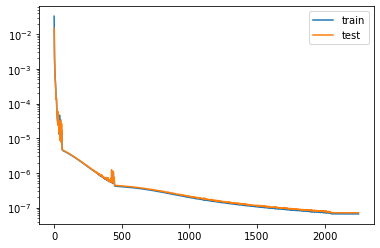

In [26]:
# plot train and test loss
plt.figure()
plt.semilogy(loss_hist['train'])
plt.semilogy(loss_hist['test'])
plt.legend(['train','test'])
plt.show()   

In [27]:
torch.cuda.empty_cache()

# Rescale

In [28]:
# # load models
# try:
#     encoder_u,decoder_u = torch.load(file_name_AE_u,map_location='cpu')
#     encoder_v,decoder_v = torch.load(file_name_AE_v,map_location='cpu')
#     print("\n--------model restored--------\n")
# except:
#     print("\n--------model not restored--------\n")
#     pass

In [29]:
# load weights and bias
en_wu1_s=encoder_u.full[0].weight.detach().numpy().astype('float32')
en_bu1=encoder_u.full[0].bias.detach().numpy().astype('float32')
en_wu2=encoder_u.full[2].weight.detach().numpy().astype('float32')

en_wv1_s=encoder_v.full[0].weight.detach().numpy().astype('float32')
en_bv1=encoder_v.full[0].bias.detach().numpy().astype('float32')
en_wv2=encoder_v.full[2].weight.detach().numpy().astype('float32')

de_wu1=decoder_u.full[0].weight.detach().numpy().astype('float32')
de_bu1=decoder_u.full[0].bias.detach().numpy().astype('float32')
de_wu2_s=decoder_u.full[2].weight.detach().numpy().astype('float32')

de_wv1=decoder_v.full[0].weight.detach().numpy().astype('float32')
de_bv1=decoder_v.full[0].bias.detach().numpy().astype('float32')
de_wv2_s=decoder_v.full[2].weight.detach().numpy().astype('float32')

de_wu2_s_sp=sp.csr_matrix(de_wu2_s,dtype='float32')
de_wv2_s_sp=sp.csr_matrix(de_wv2_s,dtype='float32')

# rescale weights
en_wu1=en_wu1_s*u_scale_reciprocal
en_wv1=en_wv1_s*v_scale_reciprocal

de_wu1T=de_wu1.T
de_wv1T=de_wv1.T

de_wu2T=u_scale*de_wu2_s.T
de_wv2T=v_scale*de_wv2_s.T

de_wu2=de_wu2T.T
de_wv2=de_wv2T.T

de_wu2_sp=sp.csr_matrix(de_wu2,dtype='float32')
de_wv2_sp=sp.csr_matrix(de_wv2,dtype='float32')

de_wu2T_sp=de_wu2_sp.T
de_wv2T_sp=de_wv2_sp.T

In [30]:
# numpy version of AE
def sigmoid_np(input):
    return (1.0/(1.0+np.exp(-input))).astype('float32')

def encoder_u_np_forward(x):
    z1 = en_wu1.dot(x) + en_bu1
    a1 = sigmoid_np(z1)
    y = en_wu2.dot(a1)   
    return y

def decoder_u_np_forward(x):
    z1 = de_wu1.dot(x) + de_bu1
    a1 = sigmoid_np(z1)
    y = de_wu2.dot(a1)  
    return y

def decoder_u_sp_forward(x):
    z1 = de_wu1.dot(x) + de_bu1
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(de_wu2_sp,a1)
    return y

def encoder_v_np_forward(x):
    z1 = en_wv1.dot(x) + en_bv1
    a1 = sigmoid_np(z1)
    y = en_wv2.dot(a1)   
    return y

def decoder_v_np_forward(x):
    z1 = de_wv1.dot(x) + de_bv1
    a1 = sigmoid_np(z1)
    y = de_wv2.dot(a1)   
    return y

def decoder_v_sp_forward(x):
    z1 = de_wv1.dot(x) + de_bv1
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(de_wv2_sp,a1)
    return y

def decoder_u_np_forward_backwardT(x):
    z1 = de_wu1.dot(x) + de_bu1
    a1 = sigmoid_np(z1)
    y = de_wu2.dot(a1)

    dout = de_wu1T
    dout = (a1*(1-a1))*dout
    dydxT = dout.dot(de_wu2T)   
    return y,dydxT

def decoder_u_sp_forward_backwardT(x):
    z1 = de_wu1.dot(x) + de_bu1
    a1 = sigmoid_np(z1)
    y = sparse.csr_matrix.dot(de_wu2_sp,a1)

    dout = de_wu1T
    dout = (a1*(1-a1))*dout
    dydxT = sp.csr_matrix.dot(dout,de_wu2T_sp)
    return y,dydxT

def decoder_v_np_forward_backwardT(x):
    z1 = de_wv1.dot(x) + de_bv1
    a1 = sigmoid_np(z1)
    y = de_wv2.dot(a1)

    dout = de_wv1T
    dout = (a1*(1-a1))*dout
    dydxT = dout.dot(de_wv2T)   
    return y,dydxT

def decoder_v_sp_forward_backwardT(x):
    z1 = de_wv1.dot(x) + de_bv1
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(de_wv2_sp,a1)

    dout = de_wv1T
    dout = (a1*(1-a1))*dout
    dydxT = sp.csr_matrix.dot(dout,de_wv2T_sp)
    return y,dydxT

In [31]:
# compute MSELoss
comp_orig_data_u=np.zeros((ndata,f))
comp_orig_data_v=np.zeros((ndata,f))

rest_orig_data_u=np.zeros(orig_data_u.shape)
rest_orig_data_v=np.zeros(orig_data_u.shape)

for k in range(ndata):
    comp_orig_data_u[k]=encoder_u_np_forward(orig_data_u[k]-u_ref)
    comp_orig_data_v[k]=encoder_v_np_forward(orig_data_v[k]-v_ref)
    
    rest_orig_data_u[k]=decoder_u_sp_forward(comp_orig_data_u[k]) + u_ref
    rest_orig_data_v[k]=decoder_v_sp_forward(comp_orig_data_v[k]) + v_ref
    
print("MSELoss of AE u: {:.8e}".format(np.linalg.norm(orig_data_u-rest_orig_data_u)**2/np.prod(orig_data_u.shape)))
print("MSELoss of AE v: {:.8e}".format(np.linalg.norm(orig_data_v-rest_orig_data_v)**2/np.prod(orig_data_v.shape)))

MSELoss of AE u: 1.72900273e-08
MSELoss of AE v: 2.14844608e-08


In [32]:
# rescale AE
en_weight_u_s=encoder_u.full[0].weight.data
en_weight_u=en_weight_u_s*torch.tensor(u_scale_reciprocal)
encoder_u.full[0].weight=nn.Parameter(en_weight_u)

de_weight_u_s=decoder_u.full[2].weight.data
de_weight_u=(torch.tensor(u_scale)*de_weight_u_s.T).T
de_weight_u_mask=decoder_u.full[2].weight_mask.data
prune.remove(decoder_u.full[2],'weight');
decoder_u.full[2].weight=nn.Parameter(de_weight_u)
prune.custom_from_mask(decoder_u.full[2], name='weight', mask=de_weight_u_mask);

en_weight_v_s=encoder_v.full[0].weight.data
en_weight_v=en_weight_v_s*torch.tensor(v_scale_reciprocal)
encoder_v.full[0].weight=nn.Parameter(en_weight_v)

de_weight_v_s=decoder_v.full[2].weight.data
de_weight_v=(torch.tensor(v_scale)*de_weight_v_s.T).T
de_weight_v_mask=decoder_v.full[2].weight_mask.data
prune.remove(decoder_v.full[2],'weight');
decoder_v.full[2].weight=nn.Parameter(de_weight_v)
prune.custom_from_mask(decoder_v.full[2], name='weight', mask=de_weight_v_mask);

In [33]:
# compute MSELoss
input_u=torch.tensor(orig_data_u-u_ref)
target_u=decoder_u(encoder_u(input_u))

input_v=torch.tensor(orig_data_v-v_ref)
target_v=decoder_v(encoder_v(input_v))

print("MSELoss of AE u: {:.8e}".format(torch.nn.functional.mse_loss(input_u,target_u).detach().item()))
print("MSELoss of AE v: {:.8e}".format(torch.nn.functional.mse_loss(input_v,target_v).detach().item()))

MSELoss of AE u: 1.72896186e-08
MSELoss of AE v: 2.14838618e-08


In [34]:
# compute MSELoss (predictive case)
if Re==10000:
    FOM_solution=pickle.load(open('./data/FOM_high_Re.p','rb'))
elif Re==100:
    FOM_solution=pickle.load(open('./data/FOM_loq_Re.p','rb'))
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))
    
u_full=FOM_solution['u'].astype('float32')
v_full=FOM_solution['v'].astype('float32')

orig_data_u_FOM = u_full[:,free_raveled_indicies]
orig_data_v_FOM = v_full[:,free_raveled_indicies]

input_u_FOM=torch.tensor(orig_data_u_FOM-u_ref)
target_u_FOM=decoder_u(encoder_u(input_u_FOM))

input_v_FOM=torch.tensor(orig_data_v_FOM-v_ref)
target_v_FOM=decoder_v(encoder_v(input_v_FOM))

print("MSELoss of AE u (predictive case): {:.8e}"\
      .format(torch.nn.functional.mse_loss(input_u_FOM,target_u_FOM).detach().item()))
print("MSELoss of AE v (predictive case): {:.8e}"\
      .format(torch.nn.functional.mse_loss(input_v_FOM,target_v_FOM).detach().item()))

MSELoss of AE u (predictive case): 3.07030739e-08
MSELoss of AE v (predictive case): 3.52457974e-08


In [35]:
# # generate mesh grid
# [xv,yv]=np.meshgrid(np.linspace(0,1,nx),np.linspace(0,1,ny),indexing='xy')
# x=xv.flatten()
# y=yv.flatten()

# x_free=x[free_raveled_indicies]
# y_free=y[free_raveled_indicies]

# k=-1

# # plot origianl data
# fig_u = plt.figure()
# ax_u = Axes3D(fig_u)
# ax_u.plot_surface(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), orig_data_u[k].reshape(ny-2,nx-2),cmap=cm.viridis, rstride=1, cstride=1)
# ax_u.view_init(elev=30,azim=30)
# # ax_u = fig_u.gca()
# # p_u=ax_u.pcolor(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), orig_data_u[k].reshape(ny-2,nx-2))
# # cb_u=fig_u.colorbar(p_u,ax=ax_u)
# ax_u.set_xlabel('$x_{free}$')
# ax_u.set_ylabel('$y_{free}$')
# plt.title('Original $u$')
# plt.show()

# fig_v = plt.figure()
# ax_v = Axes3D(fig_v)
# ax_v.plot_surface(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), orig_data_v[k].reshape(ny-2,nx-2),cmap=cm.viridis, rstride=1, cstride=1)
# ax_v.view_init(elev=30,azim=60)
# # ax_v = fig_v.gca()
# # p_v=ax_v.pcolor(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), orig_data_v[k].reshape(ny-2,nx-2))
# # cb_v=fig_v.colorbar(p_v,ax=ax_v)
# ax_v.set_xlabel('$x_{free}$')
# ax_v.set_ylabel('$y_{free}$')
# plt.title('Original $v$')
# plt.show()

# # plot compressed data
# plt.figure()
# plt.plot(comp_orig_data_u[k])
# plt.title('Compressed $u$')
# plt.show()

# plt.figure()
# plt.plot(comp_orig_data_v[k])
# plt.title('Compressed $v$')
# plt.show()

# # plot restored data
# fig_u = plt.figure()
# ax_u = Axes3D(fig_u)
# ax_u.plot_surface(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), rest_orig_data_u[k].reshape(ny-2,nx-2),cmap=cm.viridis, rstride=1, cstride=1)
# ax_u.view_init(elev=30,azim=30)
# # ax_u = fig_u.gca()
# # p_u=ax_u.pcolor(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), rest_orig_data_u[k].reshape(ny-2,nx-2))
# # cb_u=fig_u.colorbar(p_u,ax=ax_u)
# ax_u.set_xlabel('$x_{free}$')
# ax_u.set_ylabel('$y_{free}$')
# plt.title('Restored $u$')
# plt.show()

# fig_v = plt.figure()
# ax_v = Axes3D(fig_v)
# ax_v.plot_surface(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), rest_orig_data_v[k].reshape(ny-2,nx-2),cmap=cm.viridis, rstride=1, cstride=1)
# ax_v.view_init(elev=30,azim=60)
# # ax_v = fig_v.gca()
# # p_v=ax_v.pcolor(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), rest_orig_data_v[k].reshape(ny-2,nx-2))
# # cb_v=fig_v.colorbar(p_v,ax=ax_v)
# ax_v.set_xlabel('$x_{free}$')
# ax_v.set_ylabel('$y_{free}$')
# plt.title('Restored $v$')
# plt.show()

# # plot relative error
# fig_u = plt.figure()
# ax_u = Axes3D(fig_u)
# ax_u.plot_surface(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), (orig_data_u[k]-rest_orig_data_u[k]).reshape(ny-2,nx-2),cmap=cm.viridis, rstride=1, cstride=1)
# ax_u.view_init(elev=30,azim=30)
# # ax_u = fig_u.gca()
# # p_u=ax_u.pcolor(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), (orig_data_u[k]-rest_orig_data_u[k]).reshape(ny-2,nx-2))
# # cb_u=fig_u.colorbar(p_u,ax=ax_u)
# ax_u.set_xlabel('$x_{free}$')
# ax_u.set_ylabel('$y_{free}$')
# plt.title('Difference $u$')
# plt.show()

# fig_v = plt.figure()
# ax_v = Axes3D(fig_v)
# ax_v.plot_surface(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), (orig_data_v[k]-rest_orig_data_v[k]).reshape(ny-2,nx-2),cmap=cm.viridis, rstride=1, cstride=1)
# ax_v.view_init(elev=30,azim=60)
# # ax_v = fig_v.gca()
# # p_v=ax_v.pcolor(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), (orig_data_v[k]-rest_orig_data_v[k]).reshape(ny-2,nx-2))
# # cb_v=fig_v.colorbar(p_v,ax=ax_v)
# ax_v.set_xlabel('$x_{free}$')
# ax_v.set_ylabel('$y_{free}$')
# plt.title('Difference $v$')
# plt.show()

In [36]:
# save weights and references   
AE={'en_wu1':en_wu1,'en_bu1':en_bu1,'en_wu2':en_wu2,
    'de_wu1':de_wu1,'de_bu1':de_bu1,'de_wu2':de_wu2,
    'de_wu1T':de_wu1T,'de_wu2T':de_wu2T,'de_wu2_sp':de_wu2_sp,'de_wu2T_sp':de_wu2T_sp,'u_ref':u_ref,
    'en_wv1':en_wv1,'en_bv1':en_bv1,'en_wv2':en_wv2,
    'de_wv1':de_wv1,'de_bv1':de_bv1,'de_wv2':de_wv2,
    'de_wv1T':de_wv1T,'de_wv2T':de_wv2T,'de_wv2_sp':de_wv2_sp,'de_wv2T_sp':de_wv2T_sp,'v_ref':v_ref}

pickle.dump(AE,open(file_name_AE,'wb'))